<a href="https://colab.research.google.com/github/mthomp89/landslide-detect/blob/main/BIG_SUR_Landslide_Version_of_Detecting_Changes_in_Sentinel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Changes in Sentinel-1 Imagery For Verified Lanslide Locations 

Authors: Leah Manak and Mitch Thompson.
Special credit to: Elsa Culler




#### License
@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
Licensed under the Apache License, Version 2.0 (the "License"); you may not use 
this file except in compliance with the License. You may obtain a copy of the 
License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed 
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR 
CONDITIONS OF ANY KIND, either express or implied. See the License for the 
specific language governing permissions and limitations under the License.

### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWhqFyXLcHKaZYokLH-Rq1lvRkgHJ7rmFOn-m0KT-CeggqJVQamNuGA

Successfully saved authorization token.


### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) that will be used in the tutorial is:

- COPERNICUS/S1_GRD_FLOAT
    - Sentinel-1 ground range detected images

Another is a verified landslide locations dataset created by CU Boulder Earth Lab that will be defined below as "landslide_df". 
- This dataset includes various verified locations of landslides across North America with descriptions of severity and type. 
The following cell imports some python modules which we will be using as we go along and enables inline graphics.

In [13]:
import os
import json
import earthpy as et
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.det import det
from src.create_dataframe import create_dataframe
from src.image_search import image_search
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geemap
import ipyleaflet
import ipywidgets

%matplotlib inline

This cell carries over the chi square cumulative distribution function and the determinant of a Sentinel-1 image from [Part 2 of earth-engine tutorial. (https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2).

In [14]:
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """

    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

To make use of interactive graphics, we import the _folium_ package:
- here we may also import geemap as well if we choose to make an interactive split map before/after landslide event. 

In [15]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds Earth Engine layers to a folium map."""
    
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## Set working directory
I created a folder in our "earth-analytics" folder that is titled "landslide-detect". Here, we can add our datasets so we can both access them the same way through this notebook. 
-We still need to find a way to have this be more reproducible. There should be a way to have this csv on Git Hub for future downloads so we don't have to do it manually on our own computer. 

In [16]:
# Change directory to landslide-detect data path
data_path = os.path.join(et.io.HOME, "earth-analytics", "landslide-detect")
if os.path.exists(data_path):
    os.chdir(data_path)
else:
    os.makedirs(data_path)
    print('The new directory is created!')
    os.chdir(data_path)

print('Current working directory is set to: ', os.getcwd())

Current working directory is set to:  /Users/leahmanak/earth-analytics/landslide-detect


## Create a Pandas Dataframe of the verified landslides
This dataframe is from the landslides.verified.csv. We are currently adding the minx, miny, maxx, maxy values as a "bounding box" for the locations, however this should be overwritten with a 1km buffer using BBox class. 

In [17]:
# Open CSV and Create DataFrame with Pandas
landslide_gdf = create_dataframe('landslides.verified.csv')
landslide_gdf.head()

,slide.date,location,type,trigger,size,lon,lat,location_accuracy,event_title,admin_division_name,ge.lat,ge.lon,is.exact,slide.index,geometry
slide.id,,,,,,,,,,,,,,,
10032,2017-07-11T21:47:00Z,Cassville rock slide,landslide,rain,medium,-90.999234,42.721873,5km,Cassville rock slide,NA,NA,NA,FALSE,115,POINT (-90.99923 42.72187)
10034,2016-09-20T14:24:00Z,Balligomingo Road Mudslide,mudslide,rain,medium,-75.325703,40.070575,1km,Balligomingo Road Mudslide,NA,40.070575000000005,-75.32570277777778,TRUE,127,POINT (-75.32570 40.07058)
10063,2016-07-02T12:55:00Z,Mudslide closes Highway 837,mudslide,rain,medium,-112.911742,51.575712,1km,Mudslide closes Highway 837,NA,NA,NA,FALSE,152,POINT (-112.91174 51.57571)
10120,2017-01-06T18:08:00Z,Multiple Rockslides along Highway 1 near Ragge...,rock_fall,rain,medium,-121.328879,35.779001,1km,Multiple Rockslides along Highway 1 near Ragge...,NA,NA,NA,FALSE,166,POINT (-121.32888 35.77900)
10121,2017-03-05T16:52:00Z,New Camaldoli Hermitage Monks Trapped by Mudsl...,mudslide,rain,medium,-121.531978,36.018678,5km,New Camaldoli Hermitage Monks Trapped by Mudsl...,NA,36.018677777777775,-121.53197777777778,TRUE,162,POINT (-121.53198 36.01868)


## Folium Map of All Verified Landslide Locations

In [18]:
verified_locations = landslide_gdf[["lat", "lon", "type"]]

mp = folium.Map(
    location=[verified_locations.lat.mean(), verified_locations.lon.mean()],
    zoom_start=4,
    control_scale=True,
    tiles="Stamen Terrain")

for index, location_info in landslide_gdf.iterrows():
    folium.Marker([location_info["lat"], location_info["lon"]], popup=location_info["type"]).add_to(mp)

display(mp) 
                 

## Multitemporal change detection


In order to accurately detect land-change due to lanslides, we need to gather information across a time series to determine the changes that occured and to get accurate location information for the landslides. To get started, we need to create a time series for each location.

### A time series
For now, we are creating the geoJSON bounding box by hand for our initial study sites: Big Sur and Wyoming.

The following code will be for both Big Sur and Wyoming loctions of landslides that occured in 2017. The boundaries for each location are identified, and the coordinate marker on the folium map are the "verified" locations identified from our database.
- Since we are just experimenting now on what two sites will look like, we have the same code copied for both sites, thus one needs to be commented out while running the code to avoid errors. We will need to only have one geoJSON version at the end that will run all locations cited in the folium map above, however for now we have a separate value for both sites. Each place in the code will be marked as either the Big Sur site or the Wyoming site for now. 

In [59]:
# # Big Sur site id #9734
# geoJSON = os.path.join('inputs', 'big_sur_siteid_9734.json')

# Wyoming site id #9806
geoJSON = os.path.join('inputs', 'wyoming_siteid_9806.json')

In [60]:
with open(geoJSON, encoding='utf-8') as f:
    geoJSON = json.load(f)

coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

#### Big Sur AOI

In [61]:
# # BIG SUR/ make sure the geoJSON for BIG SUR is not commented out to run this code:
# m = folium.Map(location=[35.865628, -121.4323838],
#                zoom_start=15, tiles="Stamen Terrain")
# folium.Marker([35.865628, -121.4323838],
#               popup="<i>Big Sur Landslide</i>").add_to(m)
# folium.GeoJson(geoJSON).add_to(m)
# # This GeoJson addition below is the bounding box for bit
# # m.add_ee_layer(aoi)
# display(m)

#### Wyoming AOI

In [62]:
# Wyoming:
m = folium.Map(location=[43.51364004, -108.1852766],
               zoom_start=11, tiles="Stamen Terrain")
folium.Marker([43.51364004, -108.1852766],
              popup="<i>Wyoming Landslide</i>").add_to(m)
folium.GeoJson(geoJSON).add_to(m)
# This GeoJson addition below is the bounding box for bit
# m.add_ee_layer(aoi)
display(m)

## Test new image_search function

In [63]:
image_search(landslide_gdf)

NameError: name 'ee' is not defined

## Big Sur Image Collection
The image collection below covers the months of September, 2016 through September, 2017 at 6-day intervals. This allows for enough timestamps for us to determine land-change. 

In [64]:
# im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
#            .filterBounds(aoi)
#            .filterDate(ee.Date('2016-09-01'), ee.Date('2017-09-01'))
#            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
#            .filter(ee.Filter.eq('relativeOrbitNumber_start', 42))
#            .filter(ee.Filter.listContains('transmitterReceiverPolarisation',
#                                           'VV'))
#            .filter(ee.Filter.listContains('transmitterReceiverPolarisation',
#                                           'VH'))
#            .map(lambda img: img.set('date',
#                                     ee.Date(img.date()).format('YYYYMMdd')))
#            .sort('date'))

# timestamplist = (im_coll.aggregate_array('date')
#                  .map(lambda d: ee.String('T').cat(ee.String(d)))
#                  .getInfo())
# timestamplist

## Wyoming Image Collection
The image collection below covers the months of September, 2016 through September, 2017 at 6-day intervals. This allows for enough timestamps for us to determine land-change. 

In [65]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
           .filterBounds(aoi)
           .filterDate(ee.Date('2016-09-01'), ee.Date('2017-09-01'))
           .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
           .filter(ee.Filter.eq('relativeOrbitNumber_start', 27))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation',
                                          'VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation',
                                          'VH'))
           .map(lambda img: img.set('date',
                                    ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())
timestamplist

['T20170217',
 'T20170217',
 'T20170301',
 'T20170301',
 'T20170313',
 'T20170313',
 'T20170325',
 'T20170325',
 'T20170406',
 'T20170406',
 'T20170418',
 'T20170418',
 'T20170430',
 'T20170430',
 'T20170512',
 'T20170512',
 'T20170524',
 'T20170524',
 'T20170605',
 'T20170605',
 'T20170629',
 'T20170629',
 'T20170711',
 'T20170711',
 'T20170723',
 'T20170723',
 'T20170804',
 'T20170804',
 'T20170816',
 'T20170816',
 'T20170828',
 'T20170828']

## Convert and Clip Image Collection
Convert the image collection to a list and, clip the images to our AOI for both sites:

In [66]:
def clip_img(img):
    """Clips a list of images."""
    return ee.Image(img).clip(aoi)

im_list = im_coll.toList(im_coll.size())


im_list = ee.List(im_list.map(clip_img))
im_list.get(0)
ee.Image(im_list.get(0)).bandNames().getInfo()
im_list.length().getInfo()

32

In [67]:
def selectvv(current):
    return ee.Image(current).select('VV')

vv_list = im_list.map(selectvv)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=15)
rgb_images = (ee.Image.rgb(vv_list.get(9), vv_list.get(10), vv_list.get(11))
              .log10().multiply(10))
mp.add_ee_layer(rgb_images, {'min': -20,'max': 0}, 'rgb composite')
mp.add_child(folium.LayerControl())

## Now we have a series of 22 SAR images for Big Sur and 32 for Wyoming, and we would like to know where and when changes have taken place.


Well, one problem is the rate of false positives. If the bitemporal tests are statistically independent, then the probability of **not** getting a false positive over a series of length $k$ is the product of not getting one in each of the $k-1$ intervals, i.e., $(1-\alpha)^{k-1}$ and the overall first kind error probability $\alpha_T$ is its complement:

$$
\alpha_T = 1-(1-\alpha)^{k-1}. \tag{3.1}
$$

For our case, even with a small value of $\alpha=0.01$, this gives a whopping 22.2% false positive rate:

In [68]:
# # Big Sur
# alpha = 0.01
# 1-(1-alpha)**22

In [69]:
# Wyoming
alpha = 0.01
1-(1-alpha)**32

0.2750196640421466

Actually things are a bit worse. The bitemporal tests are manifestly not independent because consecutive tests have one image in common. The best one can say in this situation is

$$
\alpha_T \le (k-1)\alpha, \tag{3.2}
$$

or $\alpha_T \le 25\%$ for $k=26$ and $\alpha=0.01$ . If we wish to set a false positive rate of at most, say, 1% for the entire series, then each bitemporal test must have a significance level of $\alpha=0.0004$ and a correspondingly large false negative rate $\beta$. In other words  many significant changes may be missed.

How to proceed? Perhaps by being a bit less ambitious at first and asking the simpler question: _Were there any changes at all over the interval?_ If the answer is affirmative, we can worry about how many there were and when they occurred later. Let's formulate this question as ...

### An omnibus test for change

We'll start again with the easier  single polarization case. For the series of _VV_ intensity images acquired at times $t_1, t_2,\dots t_k$, our null hypothesis is that, at a given pixel position,  there has been no change in the signal strengths $a_i=\langle|S^{a_i}_{vv}|^2\rangle$ over the entire period, i.e.,

$$
H_0:\quad a_1 = a_2 = \dots = a_k = a.
$$

The alternative hypothesis is that there was at least one change (and possibly many) over the interval. For the more mathematically inclined this can be written succinctly as

$$
H_1:\quad \exists\ i,j :\ a_i \ne a_j,
$$

which says: there exist indices $i, j$ for which $a_i$ is not equal to $a_j$.

Again, the likelihood functions are products of gamma distributions:

$$
L_1(a_1,\dots,a_k) =\prod_{i=1}^k p(s_i\mid a_i) = {1\over\Gamma(m)^k}\left[\prod_i{a_i\over m}\right]^{-m}\left[\prod_i s_i\right]^{m-1}\exp(-m\sum_i{s_i\over a_i}) \tag{3.3}
$$

$$
L_0(a)  = \prod_{i=1}^k p(s_i\mid a) = {1\over\Gamma(m)^k} \left[{a\over m}\right]^{-mk}\left[\prod_i s_i\right]^{m-1}\exp(-{m\over a}\sum_i s_i) \tag{3.4}
$$

and $L_1$ is maximized for $\hat a_i = s_i,\ i=1\dots k,$ while $L_0$ is maximized for $\hat a = {1\over k}\sum_i s_i$. So with a bit of simple algebra our likelihood ratio test statistic is

$$
Q_k = {L_0(\hat a)\over L_1(\hat a_1,\dots,\hat a_k)} = \left[k^k{\prod_i s_i\over (\sum_i s_i)^k}\right]^m \tag{3.5}
$$

and is called an _omnibus test statistic_. Note that, for $k=2$, we get the bitemporal LRT given by  [Eq. (2.10)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#the_likelihood_ratio_test).

We can't expect to find an analytical expression for the probability distribution of this LRT statistic, so we will again invoke Wilks' Theorem and work with

$$
-2 \log{Q_k} = \big[k\log{k}+\sum_i\log{s_i}-k\log{\sum_i s_i}\big](-2m) \tag{3.6}
$$

According to Wilks, it should be approximately chi square distributed with $k-1$ degrees of freedom under $H_0$. (Why?)

The input cell below evaluates the test statistic Eq. (3.6) for a list of single polarization images. We prefer from now on to use as default the equivalent number of looks 4.4 that we discussed at the end of [Part 1](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#equivalent_number_of_looks) rather than the actual number of looks $m=5$, in the hope of getting a better agreement.

In [70]:
def omnibus(im_list, m = 4.4):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

Let's see if this test statistic does indeed follow the chi square distribution. First we define a small polygon _aoi\_sub_ over the Thorne Moors (on the eastern side of the AOI) for which we hope there are few significant changes.

## Here is a comparison for pixels in _aoi\_sub_ with the chi square distribution with $k-1$ degrees of freedom. We choose the first 12 images in the series ($k=12$) for Big Sur, and 16 in Wyoming because we expect fewer changes before the landslide than over the complete sequence $k=15$, which extends past the landslide event.

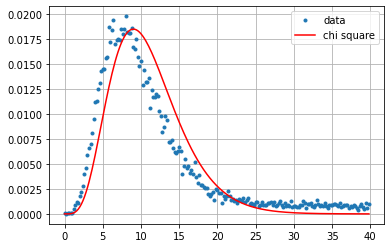

In [31]:
# # Big Sur
# k = 12
# hist = (omnibus(vv_list.slice(0,k))
#         .reduceRegion(ee.Reducer.fixedHistogram(0, 40, 200), geometry=aoi, scale=10)
#         .get('constant')
#         .getInfo())

# a = np.array(hist)
# x = a[:,0]
# y = a[:,1]/np.sum(a[:,1])
# plt.plot(x, y, '.', label='data')
# plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
# plt.legend()
# plt.grid()
# plt.show()

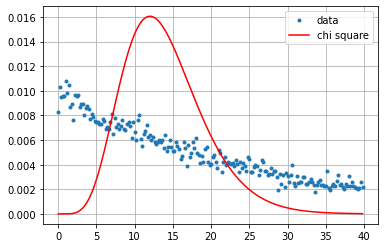

In [96]:
# Wyoming
k = 15
hist = (omnibus(vv_list.slice(0,k))
        .reduceRegion(ee.Reducer.fixedHistogram(0, 40, 200), geometry=aoi, scale=10)
        .get('constant')
        .getInfo())

a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

It appears that Wilks' Theorem is again a fairly good approximation. So why not generate a change map for the full series? The good news is that we now have the overall false positive probability $\alpha$ under control. Here we set it to $\alpha=0.01$.

In [97]:
# # The Big Sur change map for alpha = 0.01.
# k = len(timestamplist); alpha = 0.01
# p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
# c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)
# # Make the no-change pixels transparent.
# c_map = c_map.updateMask(c_map.gt(0))
# # Overlay onto the folium map.
# location = aoi.centroid().coordinates().getInfo()[::-1]
# mp = folium.Map(location=location, zoom_start=16)
# folium.Marker(
#     [35.865628, -121.4323838], popup="<i>Big Sur Landslide</i>"
# ).add_to(mp)
# mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'change map')
# mp.add_child(folium.LayerControl())

In [98]:
# The Wyoming change map for alpha = 0.01.
k = len(timestamplist); alpha = 0.01
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)
# Make the no-change pixels transparent.
c_map = c_map.updateMask(c_map.gt(0))
# Overlay onto the folium map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=13)
folium.Marker(
    [43.51364004, -108.1852766], popup="<i>Wyoming Landslide</i>"
).add_to(mp)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'change map')
mp.add_child(folium.LayerControl())

So plenty of changes, but hard to interpret considering the time span. Although we can see _where_ changes took place, we know neither _when_ they occurred nor their _multiplicity_. Also there is a matter that we have glossed over up until now, and that is ...

### A question of scale

The number of looks plays an important role in all of the formulae that we have discussed so far, and for the Sentinel-1 ground range detected imagery we first used $m=5$ and now the ENL $=4.4$.  When we display a change map interactively, the  [zoom factor determines the image pyramid level](https://developers.google.com/earth-engine/guides/scale) at which the GEE servers perform the required calculations and pass the result to the folium map client. If the calculations are not at the nominal scale of 10m then the number of looks is effectively larger than the ENL due to the averaging involved in constructing higher pyramid levels. The effect can be seen in the  output cell above: the number of change pixels seems to decrease when we zoom out. There is no problem when we export our results to GEE assets, to Google Drive or to Cloud storage, since we can simply choose the correct nominal scale for export.

In order to see the changes correctly at all zoom levels, we can force GEE to work at the nominal scale by reprojecting before displaying on the map ([use with caution](https://developers.google.com/earth-engine/guides/projections#reprojecting)):

In [99]:
# # Big Sur 
# c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
# mp = folium.Map(location=location, zoom_start=16)
# mp.add_ee_layer(c_map, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Change map')
# mp.add_ee_layer(c_map_10m, {'min': 0, 'max': 1, 'palette': ['black', 'blue']}, 'Change map (10m)')
# folium.Marker(
#     [35.865628, -121.4323838], popup="<i>Big Sur Landslide</i>"
# ).add_to(mp)
# mp.add_child(folium.LayerControl())

In [100]:
# Wyoming 
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=13)
mp.add_ee_layer(c_map, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0, 'max': 1, 'palette': ['black', 'blue']}, 'Change map (10m)')
folium.Marker(
    [43.51364004, -108.1852766], popup="<i>Wyoming Landslide</i>"
).add_to(mp)
mp.add_child(folium.LayerControl())

You will notice in the output cell above that the calculation at nominal scale (the blue pixels) now takes considerably longer to complete. Also some red pixels are not completely covered by blue ones. Those changes are a spurious result of the falsified number of looks. Nevertheless for quick previewing purposes we might prefer to do without the reprojection.

### A sequential omnibus test

Recalling the last remark at the end of [Part 2](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#oh_and_one_more_thing_), let's now guess the omnibus LRT for the dual polarization case. From Eq. (3.5), replacing $s_i \to|c_i|$,  $\ \sum s_i \to |\sum c_i|\ $ and $k^k \to k^{2k}$, we get

$$
Q_k =  \left[k^{2k}{\prod_i |c_i|\over |\sum_i c_i|^k}\right]^m. \tag{3.7}
$$

This is in fact a special case of a more general omnibus test statistic

$$
Q_k =  \left[k^{pk}{\prod_i |c_i|\over |\sum_i c_i|^k}\right]^m
$$

which holds for $p\times p$ polarimetric covariance matrix images, for example for the full dual pol matrix   [Eq. (1.5)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#single_look_complex_slc_sar_measurements) or for full $3\times 3$ quad pol matrices ($p=3$), but also for diagonal $2\times 2$ and $3\times 3$ matrices.

Which brings us to the **heart of this Tutorial**. We will now decompose Eq. (3.7) into a product of independent likelihood ratio tests which will enable us to determine when changes occurred at each pixel location. Then we'll code a complete multitemporal change detection algorithm on the GEE Python API.

#### Single polarization

Rather than make a formal derivation, we will illustrate the decomposition on a series of $k=5$ single polarization (VV) measurements. The omnibus test Eq. (3.5) for any change over the series from $t_1$ to $t_5$ is

$$
Q_5 = \left[ 5^5 {s_1s_2s_3s_4s_5\over (s_1+s_2+s_3+s_4+s_5)^5}\right]^m.
$$

If we accept the null hypothesis $a_1=a_2=a_3=a_4=a_5$ we're done and can move on to the next pixel (figuratively of course, since this stuff is all done in parallel). But suppose we have rejected the null hypothesis, i.e., there was a least one significant change. In order to find it (or them), we begin by testing the first of the four intervals. That's just the bitemporal test from Part 2, but let's call it $R_2$ rather than $Q_2$,

$$
R_2 = \left[ 2^2 {s_1s_2\over (s_1+s_2)^2}\right]^m.
$$

Suppose we conclude no change, that is, $a_1=a_2$. Now we don't do just another bitemporal test on the second interval. Instead we test the hypothesis

$$
\begin{align*}
H_0:\ & a_1=a_2= a_3\ (=a)\cr
{\rm against}\quad H_1:\  &a_1=a_2\ (=a) \ne a_3.
\end{align*}
$$

So the alternative hypothesis is: _There was no change in the first interval **and** there was a change in the second interval_. The LRT is easy to derive, but let's go through it anyway.

$$
\begin{align*}
        {\rm From\ Eq.}\ (3.4):\  &L_0(a)  = {1\over\Gamma(m)^3} \left[{a\over m}\right]^{-3m}\left[s_1s_2s_3\right]^{m-1}\exp(-{m\over a}(s_1+s_2+s_3)  \cr
        &\hat a = {1\over 3}(s_1+s_2+s_3) \cr
=>\           &L_0(\hat a) = {1\over\Gamma(m)^3} \left[{s_1+s_2+s_3\over 3m}\right]^{-3m}\left[s_1s_2s_3\right]^{m-1} \exp(-3m) \cr
{\rm From\ Eq.}\ (3.3):\ &L_1(a_1,a_2,a_3) = {1\over\Gamma(m)^3}\left[a_1a_2a_3\over m\right]^{-m}[s_1s_2s_3]^{m-1}\exp(-m(s_1/a_1+s_2/a_2+s_3/a_3)\cr
&\hat a_1 = \hat a_2 = {1\over 2}(s_1+s_2),\quad \hat a_3 = s_3 \cr
=>\ &L_1(\hat a_1,\hat a_2, \hat a_3) = {1\over\Gamma(m)^3}\left[(s_1+s_2)^2s_3\over 2^2m \right]^{-m}[s_1s_2s_3]^{m-1}\exp(-3m)
\end{align*}
$$

And, taking the ratio $L_0/L_1$of the maximum likelihoods,

$$
R_3 = \left[{3^3\over 2^2}{(s_1+s_2)^2s_3\over (s_1+s_2+s_3)^3}\right]^m.
$$

Not too hard to guess that, if we accept $H_0$ again, we go on to test

$$
\begin{align*}
H_0:\ a_1=a_2=a_3=a_4\ (=a)\cr
{\rm against}\quad H_1:\ a_1=a_2=a_3\ (=a) \ne a_4.
\end{align*}
$$

with LRT statistic

$$
R_4 = \left[{4^4\over 3^3}{(s_1+s_2+s_3)^3s_4\over (s_1+s_2+s_3+s_4)^4}\right]^m,
$$

and so on to $R_5$ and the end of the time series.

Now for the cool part (try it out yourself):

$$
R_2\times R_3\times R_4 \times R_5 = Q_5.
$$

So, generalizing to a series of length $k$:

**The omnibus test statistic $Q_k$ may be factored into the product of  LRT's $R_j$ which test for homogeneity in the measured reflectance signal up to and including time $t_j$, assuming homogeneity up to time $t_{j-1}$:**

$$
Q_k = \prod_{j=2}^k R_j, \quad R_j = \left[{j^j\over (j-1)^{j-1}}{(s_1+\dots +s_{j-1})^{j-1}s_j\over (s_1+\dots +s_j)^j}\right]^m,\quad j = 2\dots k.  \tag{3.8}
$$

Moreover the test statistics $R_j$ are stochastically independent under $H_0$.
This can be shown analytically, see [Conradsen et al. (2016)](https://ieeexplore.ieee.org/document/7398022) or P. 405 in my [textbook](https://www.taylorfrancis.com/books/9780429464348), but we'll show it here empirically by sampling the test statistics $R_j$ in the region _aoi\_sub_ and examining the correlation matrix.

In [101]:
def sample_vv_imgs(j):
    """Samples the test statistics Rj in the region aoi."""
    j = ee.Number(j)
    # Get the factors in the expression for Rj.
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0, j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0, j.subtract(1))).reduce(ee.Reducer.sum())
    # Put them together.
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)
    # Sample Rj.
    sample = (Rj.sample(region=aoi, scale=10, numPixels=1000, seed=123)
              .aggregate_array('VV_sum'))
    return sample

# Sample the first few list indices.
samples = ee.List.sequence(2, 5).map(sample_vv_imgs)

# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)
# print(np.corrcoef(samples.getInfo()))

The off-diagonal elements are mostly small. The not-so-small values can be attributed to sampling error or to the presence of some change pixels in the samples.

#### Dual polarization and an algorithm

With our substitution trick, we can now write down the sequential test for the dual polarization (bivariate) image time series. From Eq. (3.8) we get

$$
Q_k = \prod_{j=2}^k R_j , \quad R_j = \left[{j^{2j}\over (j-1)^{2(j-1)}}{|c_1+\dots +c_{j-1}|^{j-1}|c_j|\over |c_1+\dots +c_j|^j}\right]^m,\quad j = 2\dots k. \tag{3.9}
$$

And of course we have again to use Wilks' Theorem to get the _P_ values, so we work with

$$
-2\log{R_j} = -2m\Big[2(j\log{j}-(j-1)\log(j-1)+(j-1)\log\Big|\sum_{i=1}^{j-1}c_i \Big|+\log|c_j|-j\log\Big|\sum_{i=1}^j c_i\Big|\ \Big] \tag{3.10a}
$$

and

$$
-2\log Q_k = \sum_{j=2}^k -2\log R_j. \tag{3.10b}
$$

The statistic $-2\log R_j$ is approximately chi square distributed with two degrees of freedom. Similarly $-2\log Q_k$ is approximately chi square distributed with $2(k-1)$ degrees of freedom. Readers should satisfy themselves that these numbers are indeed the correct, taking into account that each measurement $c_i$ has two free parameters $|S^a_{vv}|^2$ and $|S^b_{vh}|^2$, see [Eq. (2.13)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#bivariate_change_detection).

Now for the algorithm:

**The sequential omnibus change detection algorithm**

With a time series of $k$ SAR images $(c_1,c_2,\dots,c_k)$,

1. Set $\ell = k$.
2. Set $s = (c_{k-\ell+1}, \dots c_k)$.
3. Perform the omnibus test $Q_\ell$ for any changes change over $s$.
4. If no significant changes are found, stop.
5. Successively test series $s$ with $R_2, R_3, \dots$ until the first significant change is met for $R_j$.
6. Set $\ell = k-j+1$ and go to 2.

|Table 3.1 |       |       |       |       |       |        |
|----------|-------|-------|-------|-------|-------|--------|
|  $\ell$  | $c_1$ | $c_2$ | $c_3$ | $c_4$ | $c_5$ |        |
| 5        |       | $R^5_2$ | $R^5_3$ | $R^5_4$ | $R^5_5$ | $Q_5$  |
| 4        |       |       | $R^4_2$ | $R^4_3$ | $R^4_4$ | $Q_4$  |
| 3        |       |       |       | $R^3_2$ | $R^3_3$ | $Q_3$  |
| 2        |       |       |       |       | $R^2_2$ | $Q_2$  |


Thus if a change is found, the series is truncated up to the point of change and the testing procedure is repeated for the rest of the series. Take for example a series of $k=5$ images. (See Table 3.1 where, to avoid ambiguity, we add superscript $\ell$ to each $R_j$ test). Suppose there is one change in the second interval only. Then the test sequence is (the asterisk means $H_0$ is rejected)

$$
Q^*_5 \to R^5_2 \to R^{5*}_3 \to Q_3.
$$

If there are changes in the second and last intervals,

$$
Q^*_5 \to R^5_2 \to R^{5*}_3 \to Q^*_3 \to R^3_2 \to R^{3*}_3,
$$

and if there are significant changes in all four intervals,

$$
Q^*_5 \to R^{5*}_2 \to Q^*_4 \to R^{4*}_2 \to Q^*_3 \to R^{3*}_2 \to Q^*_2.
$$

The approach taken in the coding of this algorithm is to pre-calculate  _P_ values for all of the $Q_\ell / R_j$ tests and then, in a second pass, to filter them to determine the points of change.



#### Pre-calculating the _P_ value array

The following code cell performs map operations on the indices $\ell$ and $j$, returning an array of _P_ values for all possible LRT statistics. For example again for $k=5$, the code calculates the _P_ values for each $R_j$ entry in Table 3.1 as a list of lists. Before calculating each row, the time series $c_1, c_2,c_3,c_4, c_5$ is sliced from $k-\ell+1$ to $k$. The last entry in each row is simply the product of the other entries,  $Q_\ell =\prod_{j=2}^\ell R_j.$

The program actually operates on the logarithms of the test statistics, Equations (3.10).


In [102]:
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # Slice the series from k-l+1 to k (image indices start from 0).
        im_list_ell = im_list.slice(k.subtract(ell), k)

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})

        # Map over j=2,3,...,l.
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # Map over l = k to 2.
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

#### Filtering the _P_ values

|Table 3.2 |       |       |       |       |       |        |
|----------|-------|-------|-------|-------|-------|--------|
|$i\ $ / $j$|      |     1 |     2 |     3 |     4 |        |
| 1        |       | $P_2$ | $P_3$ | $P_4$ | $P_5$ | $P_{Q5}$  |
| 2        |       |       | $P_2$ | $P_3$ | $P_4$ | $P_{Q4}$  |
| 3        |       |       |       | $P_2$ | $P_3$ | $P_{Q3}$  |
| 4        |       |       |       |       | $P_2$ | $P_{Q2}$  |

The pre-calculated _P_ values in _pv\_arr_ (shown schematically in Table 3.2 for $k=5$) are then scanned in nested iterations over indices $i$ and $j$ to determine the following thematic change maps:

- cmap: the interval of the most recent change, one band, byte values $\in [0,k-1]$,
- smap: the interval of the first change, one band, byte values $\in [0,k-1]$,
- fmap: the number of changes, one band, byte values $\in [0,k-1]$,
- bmap: the changes in each interval, $\ k-1$ bands, byte values $\in [0,1]$).

A boolean variable _median_ is included in the code. Its purpose is to reduce the salt-and-pepper effect in no-change regions, which is at least partly a consequence of the uniform distribution of the _P_ values under $H_0$ (see the section [A note on P values](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#a_note_on_p_values) in Part 2). If _median_ is _True_, the _P_ values for each $Q_\ell$ statistic are passed through a $5\times 5$ median filter before being compared with the significance threshold. This is not statistically kosher but probably justifiable if one is only interested in large homogeneous changes, for example flood inundations or deforestation.

Here is the code:

In [103]:
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # Create bmap band and add it to bmap image.
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # Filter Ql p value if desired.
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

The following function ties the two steps together:

In [104]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0, k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    return ee.Dictionary(pv_arr.iterate(filter_i, first))

And now we run the algorithm and display the color-coded change maps: _cmap_, _smap_ (blue early, red late) and _fmap_ (blue few, red many):

In [105]:
# # Big Sur
# result = change_maps(im_list, median=True, alpha=0.05)

# # Extract the change maps and display.
# cmap = ee.Image(result.get('cmap'))
# smap = ee.Image(result.get('smap'))
# fmap = ee.Image(result.get('fmap'))
# location = aoi.centroid().coordinates().getInfo()[::-1]
# palette = ['black', 'blue', 'cyan', 'yellow', 'red']
# mp = folium.Map(location=location, zoom_start=16)
# folium.Marker(
#     [35.865628, -121.4323838], popup="<i>Big Sur Landslide</i>"
# ).add_to(mp)
# mp.add_ee_layer(cmap, {'min': 0, 'max': 25, 'palette': palette}, 'cmap')
# mp.add_ee_layer(smap, {'min': 0, 'max': 25, 'palette': palette}, 'smap')
# mp.add_ee_layer(fmap, {'min': 0, 'max': 25, 'palette': palette}, 'fmap')
# mp.add_child(folium.LayerControl())

In [106]:
# Wyoming 
result = change_maps(im_list, median=True, alpha=0.05)

# Extract the change maps and display.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'blue', 'cyan', 'yellow', 'red']
mp = folium.Map(location=location, zoom_start=11)
folium.Marker(
    [43.51364004, -108.1852766], popup="<i>Wyoming Landslide</i>"
).add_to(mp)
mp.add_ee_layer(cmap, {'min': 0, 'max': 14, 'palette': palette}, 'cmap')
mp.add_ee_layer(smap, {'min': 0, 'max': 14, 'palette': palette}, 'smap')
mp.add_ee_layer(fmap, {'min': 0, 'max': 14, 'palette': palette}, 'fmap')
mp.add_child(folium.LayerControl())

#### Post-processing: The Loewner order

The above change maps are still difficult to interpret. But what about _bmap_, the map of changes detected in each interval? Before we look at them it makes sense to include the direction of change, i.e., the [Loewner order](https://ieeexplore.ieee.org/document/8736751), see [Part 2](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#change_direction_the_loewner_order). In the event of significant change at time $j$, we can simply determine the positive or negative definiteness (or indefiniteness) of the difference between consecutive covariance matrix pixels

$$
c_j-c_{j-1},\quad j = 2,\dots,k,
$$

to get the change direction. But we can do better. Instead of subtracting the value for the preceding image, $c_{j-1}$, we can subtract the average over all values up to and including time $j-1$ for which no change has been signalled. For example for $k=5$, suppose there are significant changes in the first and fourth (last) interval. Then to get their directions we examine the differences

$$
c_2-c_1\quad{\rm and}\quad c_5 - (c_2+c_3+c_4)/3.
$$

The running averages can be conveniently determined with the so-called _provisional means algorithm_. The average $\bar c_i$ of the first $i$ images is calculated recursively as

$$
\begin{align*}
\bar c_i &= \bar c_{i-1} + (c_i - \bar c_{i-1})/i \cr
\bar c_1 &= c_1.
\end{align*}
$$

The function _dmap\_iter_ below is iterated over the bands of _bmap_, replacing the values for changed pixels with

- 1 for positive definite differences,
- 2 for negative definite differences,
- 3 for indefinite differences.

In [107]:
def dmap_iter(current, prev):
    """Reclassifies values in directional change maps."""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # Reset avimg to current image and set i=1 if change occurred.
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

We only have to modify the _change\_maps_ function to include the change direction in the _bmap_ image:

In [108]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

Here We export all of the change maps are exported as a single image.

In [109]:
# Run the algorithm with median filter and at 1% significance.
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))
# Extract the change maps and export to assets.
cmap = ee.Image(result.get('cmap')).toDouble()
smap = ee.Image(result.get('smap')).toDouble()
fmap = ee.Image(result.get('fmap')).toDouble()
bmap = ee.Image(result.get('bmap')).toDouble()
cmaps = ee.Image.cat(cmap, smap, fmap, bmap).rename(['cmap', 'smap', 'fmap']+timestamplist[1:])

# EDIT THE ASSET PATH TO POINT TO YOUR ACCOUNT.
# assetId = 'users/leah.manak/cmaps'

# assexport = ee.batch.Export.image.toAsset(cmaps,
#                                           description='assetExportTask',
#                                           assetId=assetId, scale=10, maxPixels=1e9)

# UNCOMMENT THIS TO EXPORT THE MAP TO YOUR ACCOUNT.
#assexport.start()

The asset  _cmaps_ is shared so we can all access it:

In [110]:
# # cmaps = ee.Image('projects/leah.manak/ee-landslide-project/detecting-changes-in-sentinel-1-imagery-pt-3/cmaps')
# # Big Sur
# cmaps = cmaps.updateMask(cmaps.gt(0))

# location = aoi.centroid().coordinates().getInfo()[::-1]
# palette = ['black', 'red', 'cyan', 'yellow', 'grey']
# mp = folium.Map(location=location, zoom_start=16)
# slide_img = 'T20170606'
# cmaps.select(slide_img)
# mp.add_ee_layer(
#     cmaps.select(slide_img),
#     {'min': 0, 'max': 4, 'palette': palette},
#     slide_img)

# mp.add_child(folium.LayerControl())

In [111]:
# Wyoming
cmaps = cmaps.updateMask(cmaps.gt(0))

location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'red', 'cyan', 'yellow', 'grey']
mp = folium.Map(location=location, zoom_start=15)
slide_img = 'T20170217'
cmaps.select(slide_img)
mp.add_ee_layer(
    cmaps.select(slide_img),
    {'min': 0, 'max': 4, 'palette': palette},
    slide_img)

mp.add_child(folium.LayerControl())

EEException: Image.rename: Can't add a band named 'T20170301' to image because a band with this name already exists. Existing bands: [cmap, smap, fmap, T20170217, T20170301].

In [48]:
# test geemap
m = ipyleaflet.Map()
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Now interpretation is somewhat easier. The negative definite (cyan) changes which appear between Nov. 7 and Nov. 13 correspond to decreases in intensity of _VV_ and _VH_ reflectance and are due to wide-spread flooding. The positive definite changes (red), which gradually overlay the flooded areas in subsequent intervals, correspond to receding flood waters.

# Outlook

Without reliable ground truth we can't really claim that change maps of the kind we have just generated will be helpful for flood damage assessment or control, but their potential usefulness is quite obvious. In the next and final part of the Tutorial we will have a look at some more (possible) applications of sequential change detection with SAR imagery using GEE.